In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import wordpunct_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, clone_model
from keras.layers import Input, Embedding, LSTM, Dense
from transformers import pipeline
import tensorflow as tf
from tensorflow import keras

2023-04-23 22:31:10.126526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/henrywu/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problem Statement

Our main research question is: **Can we use the text of user reviews to predict the star ratings for reviews of businesses in Philadelphia?**

To answer this question, we'll try to build a model that takes a Yelp review and predicts the star rating. Then, to see whether star ratings accurately match sentiment analysis, we will compare both the true star rating labels and our predicted star ratings to the sentiment analysis results of a pretrained model from Hugging Face.

# Exploratory Data Analysis

## Loading Data
The initial dataset was quite large (even when we limited our focus to only Philadelphia). Thus, we had to split the `.csv` files up, which is why we have this slightly clunky import code. 

In [2]:
# load in business data
business = pd.read_json('data/yelp_academic_dataset_business.json', lines=True)
# keep only those businesses in the city with the most observations (Philadelphia)
# and only businesses which are restaurants
max_city = business['city'].value_counts().idxmax()
business = business.loc[(business['city'] == max_city) & (business['categories']).str.contains('Restaurants')]

In [50]:
# load in review data from separate csv's located in data folder
review = []
for i in range(1, 8):
    review.append(pd.read_csv(f'data/review{i}.csv'))
review = pd.concat(review, ignore_index=True)

### Inspecting `business`

We don't really have to worry about missing values for our `business` dataset. The only featurse with any missing values are `hours` and `attributes` (itself a dictionary of binary categories which describe the business, such as "nice ambiance" or "good views") which we are not planning on incorporating into our model. 

In [4]:
business.isnull().sum()/len(business.index)

business_id     0.000000
name            0.000000
address         0.000000
city            0.000000
state           0.000000
postal_code     0.000000
latitude        0.000000
longitude       0.000000
stars           0.000000
review_count    0.000000
is_open         0.000000
attributes      0.009057
categories      0.000000
hours           0.170540
dtype: float64

In [5]:
business.describe()

,latitude,longitude,stars,review_count,is_open
count,5852.000000,5852.000000,5852.000000,5852.000000,5852.000000
mean,39.974770,-75.154157,3.555964,113.761449,0.602358
std,0.048136,0.051395,0.803122,241.378560,0.489452
min,39.865466,-75.363647,1.000000,5.000000,0.000000
25%,39.947944,-75.176438,3.000000,14.000000,0.000000
50%,39.954445,-75.160408,3.500000,38.500000,1.000000
75%,39.999755,-75.144601,4.000000,114.000000,1.000000
max,40.141488,-74.940729,5.000000,5721.000000,1.000000


It seems that four- and five-star reviews are more common than lower ratings, which later motivates our decision to consider four and five star reviews to be positive, while considering one to three star reviews to be negative. 

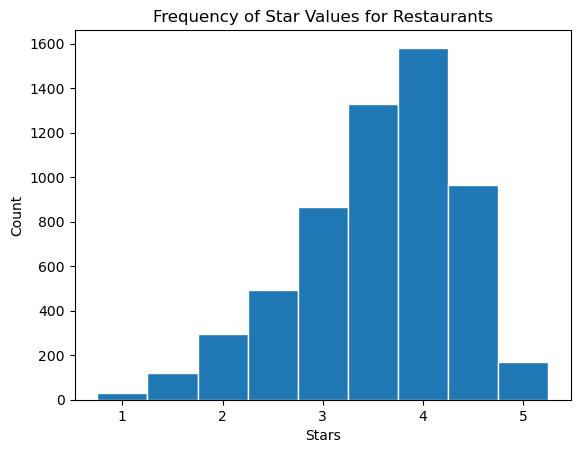

In [6]:
plt.hist(business['stars'], bins=np.arange(0.75, 5.75, 0.5), edgecolor="white")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.title("Frequency of Star Values for Restaurants")
plt.show()

The distribution of review counts in the strip plot below closely mirrors the histogram showing frequency of star values. For example, four star reviews appear the most in the dataset, and restaurants with an average of four stars often have the most reviews attributed to them. On the other hand, not many restaurants have an average of one or five stars, and those with low ratings don’t have many reviews. This suggests that when more reviews are left for a restaurant, the average rating starts to converge toward four stars.

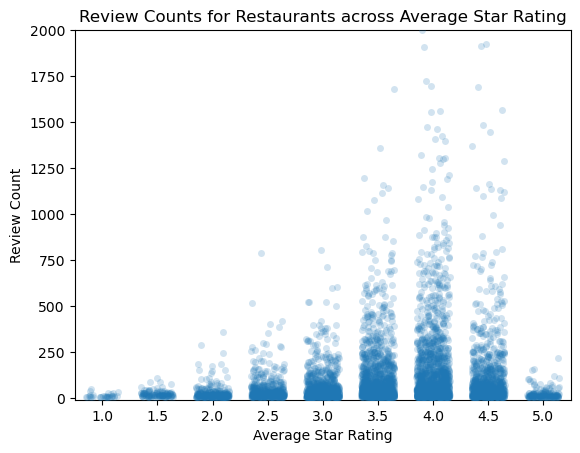

In [7]:
sns.stripplot(data=business, x='stars', y='review_count', alpha = 0.2, jitter=0.3)
plt.ylim(-10, 2000)
plt.xlabel("Average Star Rating")
plt.ylabel("Review Count")
plt.title("Review Counts for Restaurants across Average Star Rating");

### Inspecting `reviews`

In [8]:
review.isnull().sum()/len(review.index)

review_id      0.0
user_id        0.0
business_id    0.0
stars          0.0
useful         0.0
funny          0.0
cool           0.0
text           0.0
date           0.0
dtype: float64

In [9]:
review.describe()

,stars,useful,funny,cool
count,687289.000000,687289.000000,687289.000000,687289.000000
mean,3.811699,1.101761,0.370848,0.550538
std,1.306959,2.531508,1.430542,1.850401
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,1.000000
max,5.000000,224.000000,227.000000,163.000000


The distribution of stars for reviews shows a different pattern than the distribution of stars for restaurants. The plurality of reviews are five stars and there are more one-star reviews than two-star reviews, but when the reviews are averaged for each restaurant, there is a regression toward the mean effect.

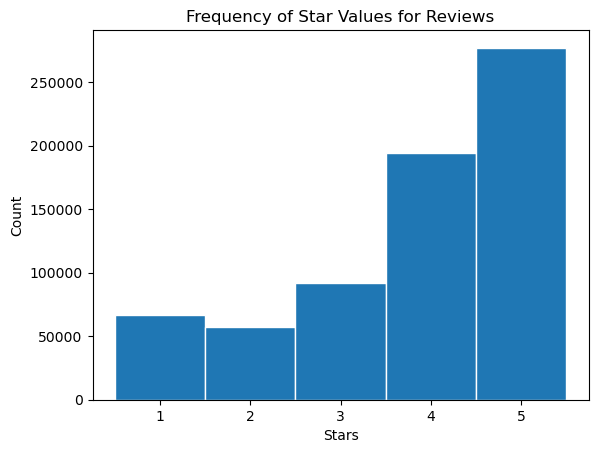

In [10]:
plt.hist(review['stars'], bins=np.arange(0.5, 6.5, 1), edgecolor="white")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.title("Frequency of Star Values for Reviews")
plt.show()

Most reviews are short and the number of reviews of a given length generally decreases as the length increases, but there are more 4500-5000 character reviews than there are 4000-4500 character reviews. The boxplots indicate that reviews for businesses with two or three stars are slightly longer while reviews for businesses with five stars tend to be shorter, but generally reviews of all star ratings follow a very similar distribution. Additionally, for all star ratings, there are many outliers with long review lengths. Because most of the reviews are shorter, when pre-processing the reviews text we should be able to truncate longer reviews without too much negative impact on model performance.

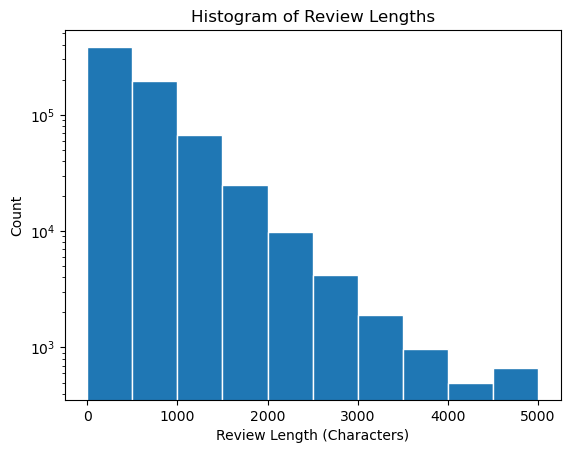

In [11]:
plt.hist(review['text'].str.len(), edgecolor="white")
plt.xlabel('Review Length (Characters)')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Histogram of Review Lengths')
plt.show()

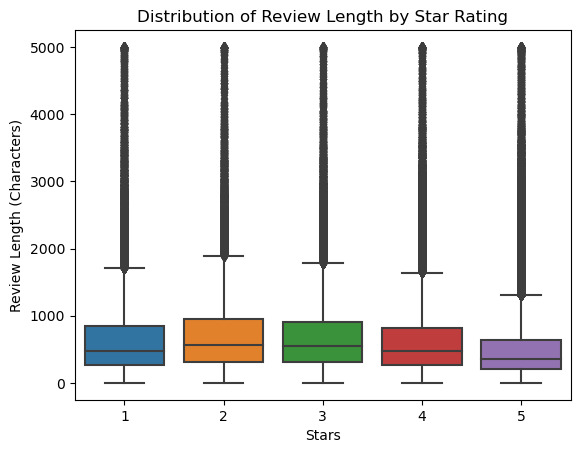

In [12]:
sns.boxplot(x=review['stars'], y=review['text'].str.len())
plt.xlabel("Stars")
plt.ylabel("Review Length (Characters)")
plt.title("Distribution of Review Length by Star Rating");

# Text Processing

In order to prepare `reviews`, we simply use `text` as our input variable and `stars` as our output variable. We then save the arrays for future use. However, in order to feed `text` into a neural network, we first had to tokenize it -- this process took a long time, so the code is commented out (so that it is not accidentally run). We utilized `wordpunct_tokenize()` in order to pre-process the text. Additionally, because we chose to pad the sequences, we started counting our word to index dictionary at 1. 

In [13]:
def clean(string):
    return wordpunct_tokenize(string.lower())

review['text'] = review['text'].apply(clean)
words = review['text'].apply(set)
words = set().union(*words)
len(words)

166581

In [14]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
f = open("data/word2idx.pkl", "wb")
pickle.dump(word2idx, f)
f.close()
X = review['text'].apply(lambda r: [word2idx[w] for w in r])
X

0        [147547, 120547, 39288, 29526, 72537, 29526, 1...
1        [158268, 42705, 6462, 98319, 45005, 82769, 292...
2        [35903, 2102, 87391, 116158, 106623, 121395, 7...
3        [65581, 19931, 57205, 67831, 79978, 30463, 108...
4        [104098, 3600, 140363, 118170, 113680, 106623,...
                               ...                        
90190    [95793, 29526, 158268, 36590, 108359, 160795, ...
90191    [158268, 148733, 47706, 134388, 108359, 106623...
90192    [158268, 154711, 38730, 76280, 65734, 129434, ...
90193    [20822, 158607, 164802, 20822, 158268, 148733,...
90194    [33373, 166207, 6462, 35903, 68395, 50749, 130...
Name: text, Length: 687289, dtype: object

In [15]:
max_words = max([len(i) for i in X])
X = pad_sequences(X, max_words)
X.shape

(687289, 1178)

In [16]:
y = review['stars'].to_numpy()
np.savez_compressed('data/reviews.npz', X=X, y=y)

# Baseline Models

First, we load in the data from `reviews.npz` and use `tensorflow` `Dataset`.

In [17]:
# for quick loading
reviews = np.load('data/reviews.npz')
X, y = reviews['X'], reviews['y'] - 1
with open('data/word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)

## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=109)

## check shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((439864, 1178),
 (439864,),
 (109967, 1178),
 (109967,),
 (137458, 1178),
 (137458,))

In [18]:
## Create data pipeline
batch_size = 1024
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(len(X_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2023-04-23 22:36:40.632262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Naive Feed Forward Network

This is the most naive approach to the problem. Given the complexity of the text, we didn't expect a feed forward neural network to perform very well, specifically because it would have issues remembering context (given that it has no recurrent relationships between different nodes).

In [19]:
ff1 = Sequential(name='Naive_FFNN')
ff1.add(Dense(64, activation='relu',input_dim=X_train.shape[1]))
ff1.add(Dense(5, activation='softmax'))
ff1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ff1.summary()

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                75456     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 75,781
Trainable params: 75,781
Non-trainable params: 0
_________________________________________________________________


In [20]:
ff1.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
430/430 [==============================] - 11s 19ms/step - loss: 2536.6926 - accuracy: 0.3634 - val_loss: 9.7356 - val_accuracy: 0.3978
Epoch 2/10
430/430 [==============================] - 12s 20ms/step - loss: 5.7857 - accuracy: 0.4016 - val_loss: 3.9239 - val_accuracy: 0.3996
Epoch 3/10
430/430 [==============================] - 11s 18ms/step - loss: 2.9500 - accuracy: 0.4026 - val_loss: 2.7431 - val_accuracy: 0.3999
Epoch 4/10
430/430 [==============================] - 21s 43ms/step - loss: 2.1850 - accuracy: 0.4029 - val_loss: 2.2464 - val_accuracy: 0.4001
Epoch 5/10
430/430 [==============================] - 14s 23ms/step - loss: 1.8605 - accuracy: 0.4030 - val_loss: 2.0258 - val_accuracy: 0.4001
Epoch 6/10
430/430 [==============================] - 14s 24ms/step - loss: 1.7076 - accuracy: 0.4031 - val_loss: 1.8739 - val_accuracy: 0.4001
Epoch 7/10
430/430 [==============================] - 10s 16ms/step - loss: 1.6220 - accuracy: 0.4031 - val_loss: 1.7809 - val_accura

As expected, this model did not perform very well. While we only trained for 10 epochs, we could see that the model accuracy on the validation set would not get much higher than 40%.

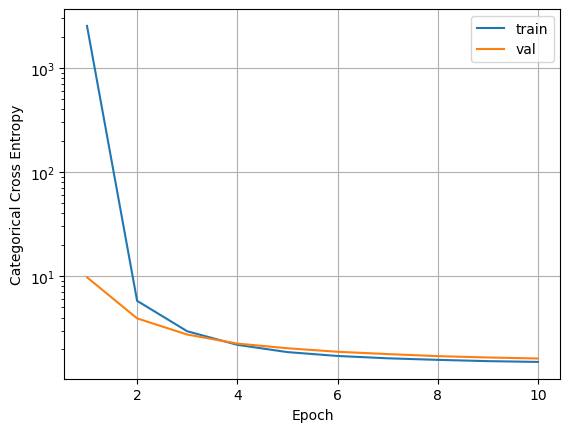

In [21]:
plt.plot(range(1, 11), ff1.history.history['loss'], label='train')
plt.plot(range(1, 11), ff1.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

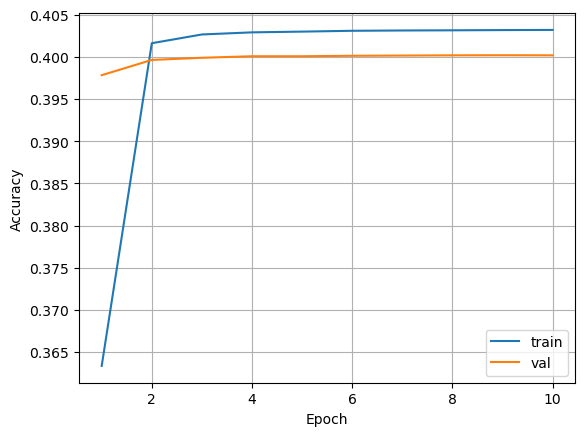

In [22]:
plt.plot(range(1, 11), ff1.history.history['accuracy'], label='train')
plt.plot(range(1, 11), ff1.history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### Evaluation

In [23]:
ff1.evaluate(test_data)

135/135 [==============================] - 1s 5ms/step - loss: 1.6690 - accuracy: 0.4057


[1.6690373420715332, 0.4057239294052124]

135/135 [==============================] - 1s 4ms/step


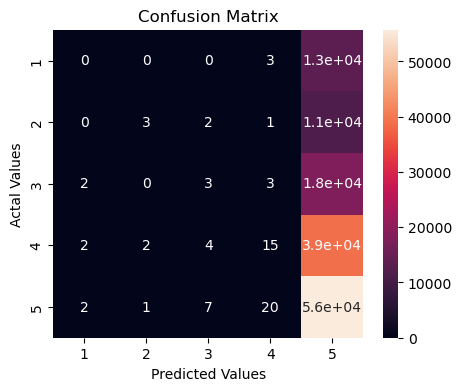

In [24]:
y_pred = np.argmax(ff1.predict(X_test, batch_size = 1024), axis = -1).flatten() 

# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('Confusion Matrix')
plt.ylabel('Actal Values') 
plt.xlabel('Predicted Values') 
plt.show()

### Downsampling

After training our baseline model, a Feed Forward Neural Network, we observed that it predicted 5 stars for almost every review because there was an over-concentration of 5-star reviews in the dataset from Yelp. This shows that the class imbalance we identified in EDA has a large negative impact on model performance. Therefore, we used downsampling to fix this for the LSTM (our first-draft of a final model). We resampled reviews for the training and validation data, restricting our downsampled data to contain 37,000 reviews from each star-class for training and around 9,000 for the validation data. This is because 2-star reviews were the least frequent class of reviews in our histograms and there were about 50,000 of them before doing the train-test split. We did not perform downsampling on the test data so that we can evaluate the model on data that accurately reflects real world data.

In [25]:
X_d_train, y_d_train, X_d_val, y_d_val = [], [], [], []

_, train_counts = np.unique(y_train, return_counts = True)
smallest_train = min(train_counts)
_, val_counts = np.unique(y_val, return_counts = True)
smallest_val = min(val_counts)

for i in range(5):
    X_di_train, y_di_train = resample(X_train[y_train == i], y_train[y_train == i], 
                                      random_state = 109, 
                                      n_samples = smallest_train, 
                                      replace = False)
    X_di_val, y_di_val = resample(X_val[y_val == i], y_val[y_val == i], 
                                  random_state = 109,
                                  n_samples = smallest_val,
                                  replace = False)
    X_d_train.append(X_di_train)
    y_d_train.append(y_di_train)
    
    X_d_val.append(X_di_val)
    y_d_val.append(y_di_val)
    
X_d_train = np.stack(X_d_train).reshape(smallest_train * 5, X.shape[1])
y_d_train = np.stack(y_d_train).flatten()

X_d_val = np.stack(X_d_val).reshape(smallest_val * 5, X.shape[1])
y_d_val = np.stack(y_d_val).flatten()

X_d_train.shape, y_d_train.shape, X_d_val.shape, y_d_val.shape

((183970, 1178), (183970,), (46725, 1178), (46725,))

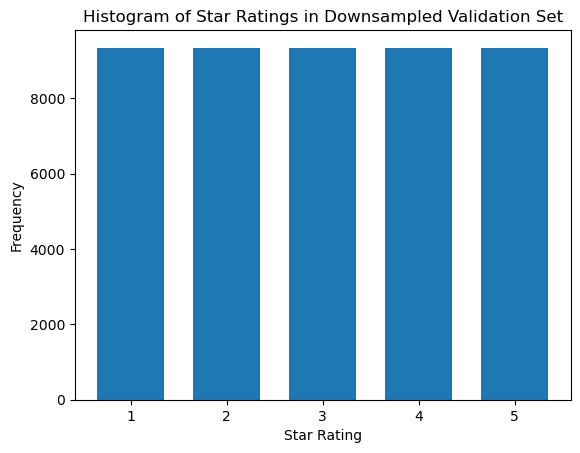

In [26]:
plt.hist(y_d_val, bins=np.linspace(-0.5, 4.5, 6), rwidth=0.7)
plt.xticks(range(5), range(1, 6))
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Star Ratings in Downsampled Validation Set')
plt.show()

In [27]:
d_train_data = tf.data.Dataset.from_tensor_slices((X_d_train, y_d_train)).shuffle(len(X_d_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
d_val_data = tf.data.Dataset.from_tensor_slices((X_d_val, y_d_val)).shuffle(len(X_d_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### Training FFNN on Downsampled Data

In [28]:
ff2 = clone_model(ff1)
ff2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ff2.summary()

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                75456     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 75,781
Trainable params: 75,781
Non-trainable params: 0
_________________________________________________________________


In [29]:
ff2.fit(d_train_data, validation_data=d_val_data, epochs=10)

Epoch 1/10
180/180 [==============================] - 3s 11ms/step - loss: 5079.8091 - accuracy: 0.2064 - val_loss: 52.0436 - val_accuracy: 0.2045
Epoch 2/10
180/180 [==============================] - 2s 10ms/step - loss: 24.4357 - accuracy: 0.2024 - val_loss: 12.8982 - val_accuracy: 0.2013
Epoch 3/10
180/180 [==============================] - 2s 10ms/step - loss: 8.3046 - accuracy: 0.2010 - val_loss: 6.8488 - val_accuracy: 0.2006
Epoch 4/10
180/180 [==============================] - 2s 10ms/step - loss: 4.7980 - accuracy: 0.1997 - val_loss: 4.8575 - val_accuracy: 0.2004
Epoch 5/10
180/180 [==============================] - 2s 10ms/step - loss: 3.4756 - accuracy: 0.1993 - val_loss: 3.8906 - val_accuracy: 0.2000
Epoch 6/10
180/180 [==============================] - 2s 9ms/step - loss: 2.8468 - accuracy: 0.1993 - val_loss: 3.3758 - val_accuracy: 0.2003
Epoch 7/10
180/180 [==============================] - 2s 10ms/step - loss: 2.4998 - accuracy: 0.1986 - val_loss: 3.0377 - val_accuracy: 0

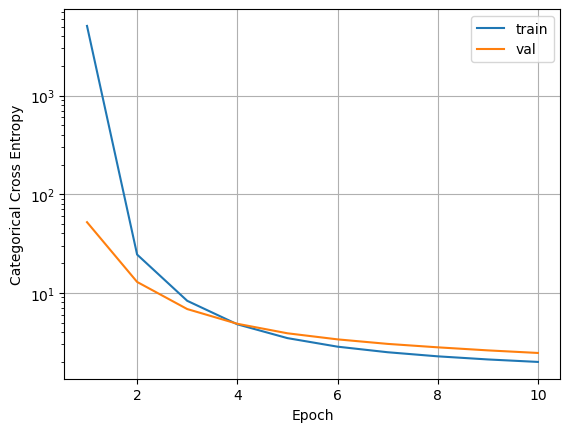

In [30]:
plt.plot(range(1, 11), ff2.history.history['loss'], label='train')
plt.plot(range(1, 11), ff2.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

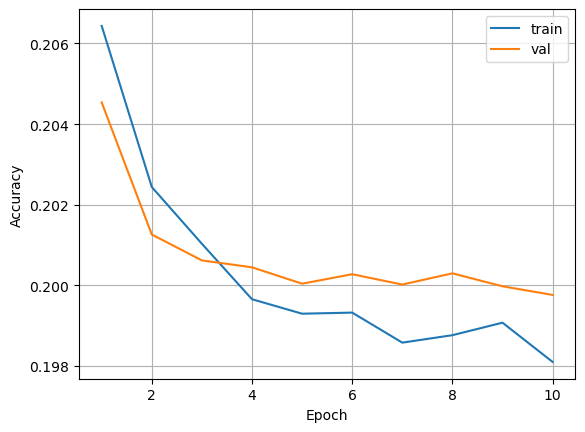

In [31]:
plt.plot(range(1, 11), ff2.history.history['accuracy'], label='train')
plt.plot(range(1, 11), ff2.history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [32]:
ff2.evaluate(test_data)

135/135 [==============================] - 2s 10ms/step - loss: 2.2722 - accuracy: 0.4053


[2.272167444229126, 0.4053165316581726]

135/135 [==============================] - 2s 11ms/step


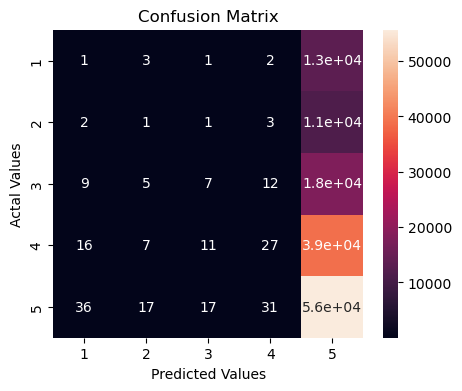

In [33]:
y_pred = np.argmax(ff2.predict(X_test, batch_size = 1024), axis = -1).flatten() 

# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('Confusion Matrix')
plt.ylabel('Actal Values') 
plt.xlabel('Predicted Values') 
plt.show()

## LSTM

For our final model, we decided to use LSTM. Given that our naive model performed poorly, even after downsampling, we decided that a language model was necessary in order to get the level of test accuracy we desired (at least >75%). In the initial draft of our final model, we were able to achieve training accuracy of 75% and testing accuracy of 60% on our dataset after around 10 epochs. However, we found that our model suffered from overfitting (after around 5 epochs, the validation loss began to rise quickly). 

In future iterations of this model, we hope to add ELMo embeddings. This is better than the standard Keras Embedding layer (word2vec) that we used in first training the LSTM model because ELMo works bidirectionally (considering semantic contexts from before and after a word in a sentence) whereas word2vec only works in one direction. Further, ELMo embeddings are created on a character-basis–not on a word basis–so that our model can learn contexts of words it hasn’t yet encountered. This could be useful in our context because all of the data has been generated by people, prone to errors like spelling mistakes. The ELMo embeddings will let us reflect contexts of mis-spelled/erroneous words.

In [34]:
inputs = Input(shape=(X_d_train.shape[1],))
n = Embedding(len(word2idx) + 1, 32, mask_zero=True)(inputs)
n = LSTM(32)(n)
outputs = Dense(5, activation='softmax')(n)
lstm = Model(inputs=inputs, outputs=outputs, name="LSTM")
lstm.summary()
lstm.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1178)]            0         
                                                                 
 embedding (Embedding)       (None, 1178, 32)          5330624   
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,339,109
Trainable params: 5,339,109
Non-trainable params: 0
_________________________________________________________________


In [35]:
lstm.fit(d_train_data, validation_data=d_val_data, epochs=5)

Epoch 1/5
180/180 [==============================] - 775s 4s/step - loss: 1.2612 - accuracy: 0.4154 - val_loss: 1.0081 - val_accuracy: 0.5514
Epoch 2/5
180/180 [==============================] - 692s 4s/step - loss: 0.9388 - accuracy: 0.5834 - val_loss: 0.9217 - val_accuracy: 0.5958
Epoch 3/5
180/180 [==============================] - 801s 4s/step - loss: 0.8574 - accuracy: 0.6292 - val_loss: 0.9110 - val_accuracy: 0.6011
Epoch 4/5
180/180 [==============================] - 637s 4s/step - loss: 0.8093 - accuracy: 0.6559 - val_loss: 0.9223 - val_accuracy: 0.5993
Epoch 5/5
180/180 [==============================] - 406s 2s/step - loss: 0.7734 - accuracy: 0.6745 - val_loss: 0.9428 - val_accuracy: 0.5949


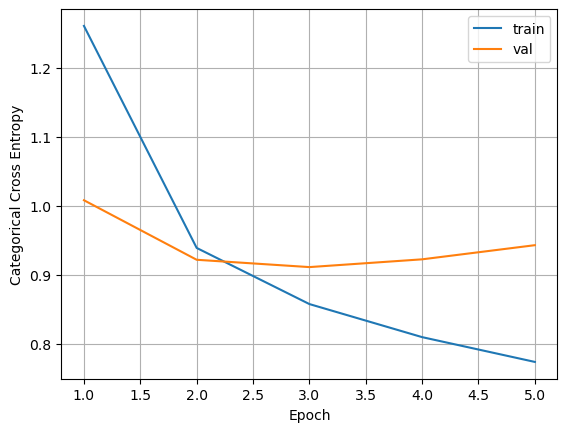

In [38]:
plt.plot(range(1, 6), lstm.history.history['loss'], label='train')
plt.plot(range(1, 6), lstm.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.legend()
plt.grid()
plt.show()

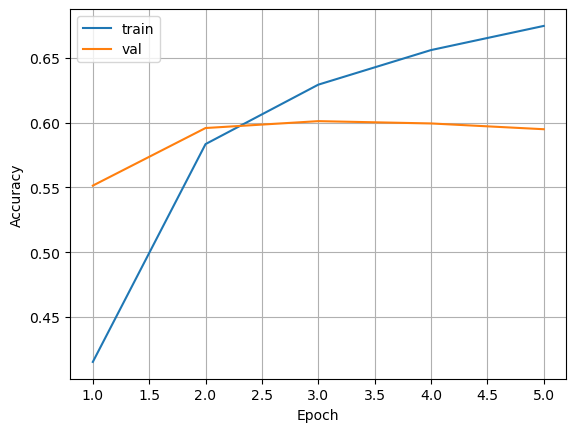

In [40]:
plt.plot(range(1, 6), lstm.history.history['accuracy'], label='train')
plt.plot(range(1, 6), lstm.history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### Evaluation
In order to test this model on new input, we created a simple function which tokenized and padded sample reviews. It seems that our model is fairly close to predicting stars in the same way we would (when we use `argmax` to find the class with the highest probability). In particular, the model is good at predicting the extreme negativity expressed in the final review we tested. 

In [41]:
lstm.evaluate(test_data)

135/135 [==============================] - 116s 842ms/step - loss: 0.8906 - accuracy: 0.6197


[0.8905832171440125, 0.6197311282157898]

135/135 [==============================] - 117s 857ms/step


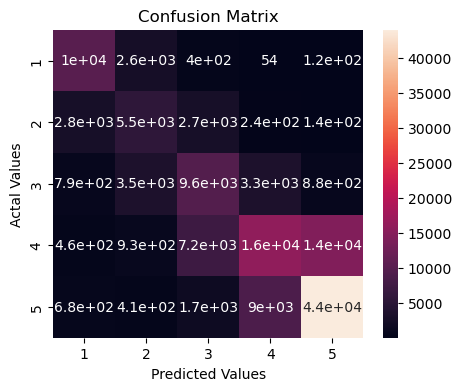

In [42]:
y_pred = np.argmax(lstm.predict(X_test, batch_size = 1024), axis = -1).flatten() 

# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('Confusion Matrix')
plt.ylabel('Actal Values') 
plt.xlabel('Predicted Values') 
plt.show()

In [43]:
def as_input(string):
    return pad_sequences(np.array([[word2idx[w] for w in wordpunct_tokenize(string.lower())]]), X.shape[1])

In [44]:
lstm.predict(as_input('This food is so bad'))

1/1 [==============================] - 0s 65ms/step


array([[0.29352084, 0.21051627, 0.17020495, 0.14848106, 0.17727688]],
      dtype=float32)

In [45]:
lstm.predict(as_input('This food is so good'))

1/1 [==============================] - 0s 53ms/step


array([[0.12018675, 0.1498313 , 0.21276823, 0.247159  , 0.27005476]],
      dtype=float32)

In [46]:
lstm.predict(as_input('One of the worst places Ive been, unfortunately! Rude staff, horrible service and tasteless food and coffee. Would never come back or recommend this place.'))

1/1 [==============================] - 0s 66ms/step


array([[9.5865709e-01, 3.9575685e-02, 1.4234483e-03, 1.6022241e-04,
        1.8354354e-04]], dtype=float32)

# Sentiment Analysis with Hugging Face Model

Based on the work we did in the most recent lab, we would also like to expand our project to include a sentiment analysis. To classify the sentiment of the reviews, we will use a pipeline from Hugging Face. The code below shows how the sentiment analysis pipeline performs on the first five reviews in our dataset, and it seems to be fairly accurate even without any fine tuning.

As noted in our previous milestone, we thought that we could map four- and five-star reviews into a “positive” category, while one- through three-star reviews would be “negative.” We plan to compare sentiments to users’ star reviews by creating a stacked bar chart: Each bar will represent a number of stars, and the stacks will be based on the number of positive and negative reviews in each star category. This should show us whether users deemed to have written negative reviews actually assign one-three stars to those businesses, or if they are perhaps too sympathetic and leave four-five stars despite writing bad reviews. We expect the results of the three-star bar to be most interesting because it’s plausible that some users associate three stars with positivity/neutrality while others associate it with negativity.


In [47]:
cls = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [65]:
# Need to truncate data to 512 characters to be able to use the pipeline
review_trunc = review['text'].apply(lambda s: s if len(s) <= 512 else s[:512])

In [71]:
for i in range(5):
  print(f'Review {i+1}:\n' + review_trunc[i])
  print()

Review 1:
Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korma.  With 10 different kinds of naan!!!  Don't let the outside deter you (because we almost changed our minds)...go in and try something new!   You'll be glad you did!

Review 2:
I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick reach your ass? Yes? Go fuck yourself! I'm a frequent customer AND great tipper. Glad that Kanella just opened. NEVER going back to dmitris!

Review 3:
Good food--loved the gnocchi with marinara
the baked eggplant appetizer was very good too

The service was very slow, but despite this, I'd go back, the food is just that good

Review 4:
Tremendous service (Big shout out to Douglas) that complemented the delicious food. Pretty expensive establishment (40-50$ avg for your main course), but its definitely backs that up with an atmo

In [73]:
cls(list(review_trunc[0:5]))

[{'label': 'POSITIVE', 'score': 0.9997116923332214},
 {'label': 'NEGATIVE', 'score': 0.997217059135437},
 {'label': 'POSITIVE', 'score': 0.9995474219322205},
 {'label': 'POSITIVE', 'score': 0.9997289776802063},
 {'label': 'POSITIVE', 'score': 0.9997133612632751}]